### Imports and Installations

In [1]:
import spacy
import en_core_web_sm
nlp_spacy_core_web_lg = en_core_web_sm.load()


In [2]:
pip install transformers

     |████████████████████████████████| 2.6 MB 7.1 MB/s 
     |████████████████████████████████| 3.3 MB 33.5 MB/s 
     |████████████████████████████████| 636 kB 53.8 MB/s 
     |████████████████████████████████| 895 kB 74.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

In [4]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

from lightgbm import LGBMClassifier

import tensorflow as tf
import tensorflow_hub as hub

from transformers import BertTokenizer

In [5]:
import os
import pandas as pd
# misc
import os
import re
import time
import ast
import warnings
import math
import copy
import matplotlib.pyplot as plt
from xgboost import plot_importance
import seaborn as sns

# data
import pandas as pd
import numpy as np
import csv

# ML
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn import metrics

!pip install scikit-plot
import scikitplot as skplt
import xgboost 

In [6]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

from lightgbm import LGBMClassifier

import tensorflow as tf
import tensorflow_hub as hub

from transformers import BertTokenizer

In [7]:
from google.colab import drive 
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Datasets')

Mounted at /content/drive


### Import and Pre-process Datasets

In [8]:
headlines = pd.read_excel("Headlines_Tokenized.xlsx")
df = pd.read_csv("DatasetFull.csv", encoding = 'latin-1')
af_headlines = pd.read_csv("AdFontes Article Classifications.csv", encoding = "latin-1")
babe = pd.read_csv("final_labels_SG2.xlsx - Sheet1.csv")

In [9]:
df['Label'] = df.Bias.apply(lambda x: 1 if x == "AllSides Media Bias Rating: Left" or x == "AllSides Media Bias Rating: Right" else (0 if x == "AllSides Media Bias Rating: Center" else -99))
headlines['Label'] = headlines.Bias.apply(lambda x: 1 if x == "AllSides Media Bias Rating: Left" or x == "AllSides Media Bias Rating: Right" else (0 if x == "AllSides Media Bias Rating: Center" else -99))
af_headlines['Label'] = af_headlines.Bias.apply(lambda x: 1 if (x > 10) | (x < -10) else (0 if (x < 5) & (x > -5) else -99))
babe['Label'] = babe.label_bias.apply(lambda x: 1 if x == "Biased" else 0)

In [10]:
df = df[df["Label"] > -50]
df = df.reset_index()

af_headlines = af_headlines[af_headlines["Label"] > -50]
af_headlines = af_headlines.reset_index()

In [11]:
df['Label'].value_counts()

1    4482
0    4168
Name: Label, dtype: int64

In [12]:
af_headlines['Label'].value_counts()

0    2536
1    1980
Name: Label, dtype: int64

In [13]:
babe['Label'].value_counts()

0    1864
1    1810
Name: Label, dtype: int64

In [14]:
x = df.drop(['Label', 'Bias'], 1)
y = df[['Label']]

In [15]:
# train-test split
train_features, test_features, train_labels, test_labels = train_test_split(x, y,
                                                                                                             test_size = 0.10, random_state = 42)
train_features1, val_features, train_labels1, val_labels = train_test_split(train_features, train_labels,
                                                                                                             test_size = 0.10, random_state = 42)

In [16]:
x_b = babe[['text']]
y_b = babe[['Label']]

In [17]:
train_features_b, test_features_b, train_labels_b, test_labels_b = train_test_split(x_b, y_b, test_size = 0.10, random_state = 42)
train_features1_b, val_features_b, train_labels1_b, val_labels_b = train_test_split(train_features_b, train_labels_b, test_size = 0.10, random_state = 42)

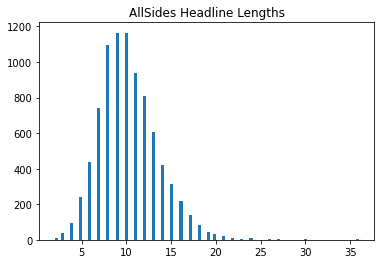

In [18]:
def plot_headline_len(dataf, col, title):
    dataf['len_' + col] = dataf[col].apply(lambda txt: len(txt.split()))
    plt.hist(dataf['len_' + col], bins = 100)
    plt.title(title)
    plt.show()
    return dataf

col = 'Headline'
df = plot_headline_len(df, col, 'AllSides Headline Lengths')

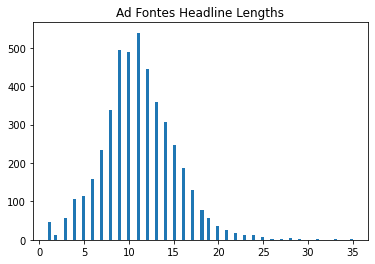

In [19]:
af_headlines = plot_headline_len(af_headlines, col, 'Ad Fontes Headline Lengths')

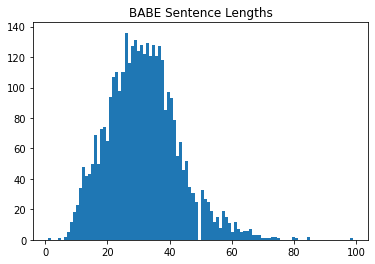

In [20]:
col = 'text'
babe = plot_headline_len(babe, col, 'BABE Sentence Lengths')

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [22]:
def tokenize_txts(txts, max_len = 40):
    res = tokenizer(
        text = [tokenizer.tokenize(txt) for txt in txts],
        max_length = max_len,
        padding = 'max_length',
        truncation = True,
        is_split_into_words = True,
    )
    return {
        'input_word_ids': res['input_ids'],
        'input_mask': res['attention_mask'],
        'input_type_ids': res['token_type_ids'],
    }

def detokenize_txt(token):
    res = tokenizer.decode(token)
    return res

In [23]:
MAX_LEN = 40
BATCH_SIZE = 32

In [24]:
train_txts_a, test_txts_a, y_train_a, y_test_a = train_test_split(
    af_headlines['Headline'].values, af_headlines['Label'].values,
    shuffle = True, test_size = 0.15,
    stratify = af_headlines['Label'].values,
)

print('Train size:', train_txts_a.shape)
print('Test size:', test_txts_a.shape)

Train size: (3838,)
Test size: (678,)


In [25]:
train_txts_ac, test_txts_ac, y_train_ac, y_test_ac = train_test_split(
    af_headlines[(af_headlines['Bias'] > -5) & (af_headlines['Bias'] < 5)]['Headline'].values, af_headlines[(af_headlines['Bias'] > -5) & (af_headlines['Bias'] < 5)]['Label'].values,
    shuffle = True, test_size = 0.15,
    stratify = af_headlines[(af_headlines['Bias'] > -5) & (af_headlines['Bias'] < 5)]['Label'].values,
)

print('Train size:', train_txts_ac.shape)
print('Test size:', test_txts_ac.shape)

Train size: (2155,)
Test size: (381,)


In [26]:
train_txts_al, test_txts_al, y_train_al, y_test_al = train_test_split(
    af_headlines[af_headlines['Bias'] < -10]['Headline'].values, af_headlines[af_headlines['Bias'] < -10]['Label'].values,
    shuffle = True, test_size = 0.15,
    stratify = af_headlines[af_headlines['Bias'] < -10]['Label'].values,
)

print('Train size:', train_txts_al.shape)
print('Test size:', test_txts_al.shape)

Train size: (892,)
Test size: (158,)


In [27]:
train_txts_ar, test_txts_ar, y_train_ar, y_test_ar = train_test_split(
    af_headlines[af_headlines['Bias'] > 10]['Headline'].values, af_headlines[af_headlines['Bias'] > 10]['Label'].values,
    shuffle = True, test_size = 0.15,
    stratify = af_headlines[af_headlines['Bias'] > 10]['Label'].values,
)

print('Train size:', train_txts_ar.shape)
print('Test size:', test_txts_ar.shape)

Train size: (790,)
Test size: (140,)


In [28]:
train_txts_b, test_txts_b, y_train_b, y_test_b = train_test_split(
    babe['text'].values, babe['Label'].values,
    shuffle = True, test_size = 0.15,
    stratify = babe['Label'].values,
)

print('Train size:', train_txts_b.shape)
print('Test size:', test_txts_b.shape)

Train size: (3122,)
Test size: (552,)


In [30]:
train_txts, test_txts, y_train, y_test = train_test_split(
    df['Headline'].values, df['Label'].values,
    shuffle = True, test_size = 0.15,
    stratify = df['Label'].values,
)

print('Train size:', train_txts.shape)
print('Test size:', test_txts.shape)

Train size: (7352,)
Test size: (1298,)


In [33]:
col = 'Headline'

In [34]:
train_txtsr, test_txtsr, y_trainr, y_testr = train_test_split(
    df[df["Bias"] == "AllSides Media Bias Rating: Right"][col].values, df[df["Bias"] == "AllSides Media Bias Rating: Right"]['Label'].values,
    shuffle = True, test_size = 0.15,
    stratify = df[df["Bias"] == "AllSides Media Bias Rating: Right"]['Label'].values,
)

print('Train size:', train_txtsr.shape)
print('Test size:', test_txtsr.shape)

Train size: (1389,)
Test size: (246,)


In [35]:
train_txtsl, test_txtsl, y_trainl, y_testl = train_test_split(
    df[df["Bias"] == "AllSides Media Bias Rating: Left"][col].values, df[df["Bias"] == "AllSides Media Bias Rating: Left"]['Label'].values,
    shuffle = True, test_size = 0.15,
    stratify = df[df["Bias"] == "AllSides Media Bias Rating: Left"]['Label'].values,
)

print('Train size:', train_txtsl.shape)
print('Test size:', test_txtsl.shape)

Train size: (2419,)
Test size: (428,)


In [36]:
train_txtsc, test_txtsc, y_trainc, y_testc = train_test_split(
    df[df["Bias"] == "AllSides Media Bias Rating: Center"][col].values, df[df["Bias"] == "AllSides Media Bias Rating: Center"]['Label'].values,
    shuffle = True, test_size = 0.15,
    stratify = df[df["Bias"] == "AllSides Media Bias Rating: Center"]['Label'].values,
)

print('Train size:', train_txtsc.shape)
print('Test size:', test_txtsc.shape)

Train size: (3542,)
Test size: (626,)


In [37]:
train_tokens = tokenize_txts(train_txts, MAX_LEN)
test_tokens = tokenize_txts(test_txts, MAX_LEN)

test_tokensc = tokenize_txts(test_txtsc, MAX_LEN)

test_tokensr = tokenize_txts(test_txtsr, MAX_LEN)

test_tokensl = tokenize_txts(test_txtsl, MAX_LEN)

train_tokens_b = tokenize_txts(train_txts_b, MAX_LEN)
test_tokens_b = tokenize_txts(test_txts_b, MAX_LEN)
train_tokens_a = tokenize_txts(train_txts_a, MAX_LEN)
test_tokens_a = tokenize_txts(test_txts_a, MAX_LEN)

test_tokens_ac = tokenize_txts(test_txts_ac, MAX_LEN)

test_tokens_ar = tokenize_txts(test_txts_ar, MAX_LEN)

test_tokens_al = tokenize_txts(test_txts_al, MAX_LEN)

af_full = tokenize_txts(af_headlines["Headline"], MAX_LEN)
babe_full = tokenize_txts(babe["text"], MAX_LEN)


In [38]:
train_ds = tf.data.Dataset.from_tensor_slices((train_tokens, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((test_tokens, y_test))

test_dsc = tf.data.Dataset.from_tensor_slices((test_tokensc, y_testc))
test_dsr = tf.data.Dataset.from_tensor_slices((test_tokensr, y_testr))
test_dsl = tf.data.Dataset.from_tensor_slices((test_tokensl, y_testl))

test_ds_ac = tf.data.Dataset.from_tensor_slices((test_tokens_ac, y_test_ac))
test_ds_ar = tf.data.Dataset.from_tensor_slices((test_tokens_ar, y_test_ar))
test_ds_al = tf.data.Dataset.from_tensor_slices((test_tokens_al, y_test_al))

train_ds_b = tf.data.Dataset.from_tensor_slices((train_tokens_b, y_train_b))
test_ds_b = tf.data.Dataset.from_tensor_slices((test_tokens_b, y_test_b))
train_ds_a = tf.data.Dataset.from_tensor_slices((train_tokens_a, y_train_a))
test_ds_a = tf.data.Dataset.from_tensor_slices((test_tokens_a, y_test_a))
af_full_ds = tf.data.Dataset.from_tensor_slices((af_full, af_headlines["Label"]))
babe_full_ds = tf.data.Dataset.from_tensor_slices((babe_full, babe["Label"]))

train_ds = train_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

test_dsc = test_dsc.batch(BATCH_SIZE)
test_dsr = test_dsr.batch(BATCH_SIZE)
test_dsl = test_dsl.batch(BATCH_SIZE)

test_ds_ac = test_ds_ac.batch(BATCH_SIZE)
test_ds_ar = test_ds_ar.batch(BATCH_SIZE)
test_ds_al = test_ds_al.batch(BATCH_SIZE)


train_ds_b = train_ds_b.batch(BATCH_SIZE)
test_ds_b = test_ds_b.batch(BATCH_SIZE)
train_ds_a = train_ds_a.batch(BATCH_SIZE)
test_ds_a = test_ds_a.batch(BATCH_SIZE)
af_full_ds = af_full_ds.batch(BATCH_SIZE)
babe_full_ds = babe_full_ds.batch(BATCH_SIZE)

### Set-up Functions

In [39]:
class MyF1(tf.keras.metrics.Metric):
    def __init__(self, name = 'mf1_score'):
        super(MyF1, self).__init__(name)
        self.p = tf.metrics.Precision()
        self.r = tf.metrics.Recall()
        self.f1 = self.add_weight(name="f1", initializer="zeros")
    
    def update_state(self, actual, predicted, sample_weight = None):
        self.p.update_state(actual, predicted)
        self.r.update_state(actual, predicted)
        self.f1.assign(2 * self.p.result() * self.r.result() / (self.p.result() + self.r.result()))
        
    def reset_states(self, ):
        self.p.reset_states()
        self.r.reset_states()
        self.f1.assign(0.0)
    def result(self,):
        return self.f1  

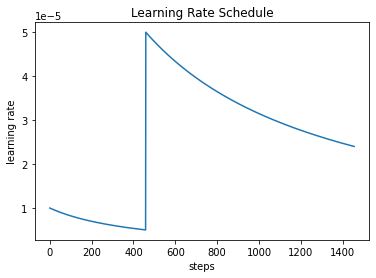

In [40]:
class CSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, lr, freeze_epoch ,batch_size, data_size):
        super(CSchedule, self).__init__()
        self.lr = lr
        self.bs = batch_size
        self.ds = data_size
        self.freeze_epoch = freeze_epoch

    def __call__(self, step):
        epoch = step /(self.ds / self.bs) + 1
        if not self.freeze_epoch or epoch < self.freeze_epoch:
            return self.lr / (tf.cast(epoch, tf.float32)+1)
        else:
            return self.lr * 10 / (tf.cast(epoch, tf.float32)+1)
        
clr = CSchedule(2e-5, 3, BATCH_SIZE, len(train_txts))
plt.plot([clr(x) for x in tf.range(1, 1457, dtype=tf.float32)])
plt.xlabel('steps')
plt.ylabel('learning rate')
plt.title('Learning Rate Schedule')
plt.show()

In [41]:
bert_handler = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

In [42]:
class MClassifier(tf.keras.Model):
    def __init__(self, dropout_rate):
        super(MClassifier, self).__init__()
        
        self.bert_layer = hub.KerasLayer(
            bert_handler,
            name = 'feature_ext',
            trainable = True,
        )
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.proba = tf.keras.layers.Dense(1, activation = 'sigmoid')

    def call(self, X_in, training):
        x = self.bert_layer(X_in, training = training)
        x = x['pooled_output']
        x = self.dropout(x, training = training)
        output = self.proba(x)
        return output

In [43]:
LEARNING_RATE = 2e-5
EPOCHS = 5
DP_RATE = 0.3

loss_objective = tf.keras.losses.BinaryCrossentropy()

In [44]:
def model_evaluation(model, ds, name):
    acc = tf.keras.metrics.BinaryAccuracy()
    f1 = MyF1()
    total_loss = []
    y_hats = []
    for X, y in ds:
        y_hat = model(X, training = False)
        loss = loss_objective(y, y_hat)
        acc.update_state(y, y_hat)
        f1.update_state(y, y_hat)
        total_loss.append(loss.numpy())
        y_hats.append(y_hat)
    y_hats = tf.concat(y_hats, axis = 0).numpy()
    print(f'{name}, loss {np.mean(total_loss):.3f}, acc {acc.result().numpy():.3f}, f1 {f1.result().numpy():.3f}')
    return y_hats, acc.result().numpy(), f1.result().numpy()

In [45]:
@tf.function
def train_step(model, tr_vars, X, y):
    with tf.GradientTape() as tape:
        y_hat = model(X, training = True)
        loss = loss_objective(y, y_hat)
    grads = tape.gradient(loss, tr_vars)
    return loss, grads, y_hat

def train_model(model, epochs, freeze_bert_on_epoch = None):
    clr = CSchedule(LEARNING_RATE, freeze_bert_on_epoch, BATCH_SIZE, len(train_txts))
    optimizer = tf.keras.optimizers.Adam(clr)
    acc = tf.keras.metrics.BinaryAccuracy()
    f1 = MyF1()
    for epoch in range(1, epochs + 1):
        
        if freeze_bert_on_epoch is not None and epoch == freeze_bert_on_epoch:
            model.get_layer('feature_ext').trainable = False
            
        acc.reset_states()
        f1.reset_states()
        total_loss = []
        for X, y in train_ds:
            tr_vars = model.trainable_variables
            loss, grads, y_hat = train_step(model, tr_vars, X, y)
            optimizer.apply_gradients(zip(grads, tr_vars))
            acc.update_state(y, y_hat)
            f1.update_state(y, y_hat)
            total_loss.append(loss.numpy())
            
        print(f'epoch {epoch}, loss {np.mean(total_loss):.3f}, acc {acc.result().numpy():.3f}, f1 {f1.result().numpy():.3f}')
        
        
    y_test_hat, _, _ = model_evaluation(model, test_ds, 'test')
    y_test_hat_c, _, _ = model_evaluation(model, test_dsc, 'test on the center')
    y_test_hat_r, _, _ = model_evaluation(model, test_dsr, 'test on the right')
    y_test_hat_l, _, _ = model_evaluation(model, test_dsl, 'test on the left')
    return y_test_hat, y_test_hat_c, y_test_hat_r, y_test_hat_l

### Results

#### Training Testing AllSides

In [46]:
model = MClassifier(DP_RATE,)
y_test_hat, y_test_hat_c, y_test_hat_r, y_test_hat_l = train_model(model, EPOCHS, freeze_bert_on_epoch = 3)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4, Total size: 429.66MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'.


epoch 1, loss 0.701, acc 0.536, f1 0.566
epoch 2, loss 0.656, acc 0.607, f1 0.634
epoch 3, loss 0.607, acc 0.675, f1 0.679
epoch 4, loss 0.603, acc 0.672, f1 0.683
epoch 5, loss 0.599, acc 0.679, f1 0.690
test, loss 0.667, acc 0.618, f1 0.630
test on the center, loss 0.636, acc 0.639, f1 nan
test on the right, loss 0.595, acc 0.700, f1 0.820
test on the left, loss 0.564, acc 0.688, f1 0.813


In [47]:
type(y_test)

numpy.ndarray

In [48]:
y_model_hat = np.array([1 if x[0] >0.5 else 0 for x in y_test_hat])

correct_list_bert = []
for i in range(len(y_model_hat)):
  if y_model_hat[i] == y_test[i]:

    correct_list_bert.append(1)
  else:
    correct_list_bert.append(0)

ran_pred = pd.Series(np.random.randint(2, size=len(y_test)))

correct_list_ran = []
for i in range(len(y_model_hat)):
  if ran_pred[i] == y_test[i]:

    correct_list_ran.append(1)
  else:
    correct_list_ran.append(0)

In [49]:
y_model_hat = np.array([1 if x[0] >0.5 else 0 for x in y_test_hat])
print(classification_report(y_test, y_model_hat))
y_model_hatc = np.array([1 if x[0] >0.5 else 0 for x in y_test_hat_c])
print(classification_report(y_testc, y_model_hatc))
y_model_hatr = np.array([1 if x[0] >0.5 else 0 for x in y_test_hat_r])
print(classification_report(y_testr, y_model_hatr))
y_model_hatl = np.array([1 if x[0] >0.5 else 0 for x in y_test_hat_l])
print(classification_report(y_testl, y_model_hatl))

              precision    recall  f1-score   support

           0       0.60      0.61      0.61       625
           1       0.63      0.63      0.63       673

    accuracy                           0.62      1298
   macro avg       0.62      0.62      0.62      1298
weighted avg       0.62      0.62      0.62      1298

              precision    recall  f1-score   support

           0       1.00      0.64      0.78       626
           1       0.00      0.00      0.00         0

    accuracy                           0.64       626
   macro avg       0.50      0.32      0.39       626
weighted avg       1.00      0.64      0.78       626

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.70      0.82       246

    accuracy                           0.70       246
   macro avg       0.50      0.35      0.41       246
weighted avg       1.00      0.70      0.82       246

              preci

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Training Testing Ad Fontes

In [50]:
@tf.function
def train_step(model, tr_vars, X, y):
    with tf.GradientTape() as tape:
        y_hat = model(X, training = True)
        loss = loss_objective(y, y_hat)
    grads = tape.gradient(loss, tr_vars)
    return loss, grads, y_hat

def train_model(model, epochs, freeze_bert_on_epoch = None):
    clr = CSchedule(LEARNING_RATE, freeze_bert_on_epoch, BATCH_SIZE, len(train_txts))
    optimizer = tf.keras.optimizers.Adam(clr)
    acc = tf.keras.metrics.BinaryAccuracy()
    f1 = MyF1()
    for epoch in range(1, epochs + 1):
        
        if freeze_bert_on_epoch is not None and epoch == freeze_bert_on_epoch:
            model.get_layer('feature_ext').trainable = False
            
        acc.reset_states()
        f1.reset_states()
        total_loss = []
        for X, y in train_ds_a:
            tr_vars = model.trainable_variables
            loss, grads, y_hat = train_step(model, tr_vars, X, y)
            optimizer.apply_gradients(zip(grads, tr_vars))
            acc.update_state(y, y_hat)
            f1.update_state(y, y_hat)
            total_loss.append(loss.numpy())
            
        print(f'epoch {epoch}, loss {np.mean(total_loss):.3f}, acc {acc.result().numpy():.3f}, f1 {f1.result().numpy():.3f}')
        
        
    y_test_hat, _, _ = model_evaluation(model, test_ds_a, 'test')
    y_test_hat_ac, _, _ = model_evaluation(model, test_ds_ac, 'test on the center')
    y_test_hat_ar, _, _ = model_evaluation(model, test_ds_ar, 'test on the right')
    y_test_hat_al, _, _ = model_evaluation(model, test_ds_al, 'test on the left')
    return y_test_hat, y_test_hat_ac, y_test_hat_ar, y_test_hat_al

In [51]:
model = MClassifier(DP_RATE,)
y_test_hat_a, y_test_hat_ac, y_test_hat_ar, y_test_hat_al = train_model(model, EPOCHS, freeze_bert_on_epoch = 3)

epoch 1, loss 0.650, acc 0.615, f1 0.523
epoch 2, loss 0.521, acc 0.739, f1 0.702
epoch 3, loss 0.420, acc 0.816, f1 0.794
epoch 4, loss 0.417, acc 0.818, f1 0.796
epoch 5, loss 0.410, acc 0.818, f1 0.794
test, loss 0.530, acc 0.738, f1 0.699
test on the center, loss 0.394, acc 0.792, f1 nan
test on the right, loss 0.599, acc 0.740, f1 0.857
test on the left, loss 0.467, acc 0.790, f1 0.883


In [52]:
y_model_hat_a = np.array([1 if x[0] >0.5 else 0 for x in y_test_hat_a])

correct_list_bert_a = []
for i in range(len(y_model_hat_a)):
  if y_model_hat_a[i] == y_test_a[i]:

    correct_list_bert_a.append(1)
  else:
    correct_list_bert_a.append(0)

ran_pred_a = pd.Series(np.random.randint(2, size=len(y_test_a)))

correct_list_ran_a = []
for i in range(len(y_model_hat_a)):
  if ran_pred_a[i] == y_test_a[i]:

    correct_list_ran_a.append(1)
  else:
    correct_list_ran_a.append(0)

In [53]:
ul = 0
ur = 0
ll = 0
lr = 0

for i in range(len(correct_list_bert)):
  if correct_list_bert[i] == 1 and correct_list_ran[i] == 1:
    ul += 1
  elif correct_list_bert[i] == 1 and correct_list_ran[i] == 0:
    ur += 1
  elif correct_list_bert[i] == 0 and correct_list_ran[i] == 1:
    ll += 1
  elif correct_list_bert[i] == 0 and correct_list_ran[i] == 0:
    lr += 1
  else:
    print("Uhhh I think something went wrong, no other scenario seems possible")

table = [[ul, ur],
         [ll, lr]]
print("AllSides BERT vs Random:", table)

from statsmodels.stats.contingency_tables import mcnemar
result = mcnemar(table, exact=True)

print(result)

print("----------------------------------------------------------")

ul_a = 0
ur_a = 0
ll_a = 0
lr_a = 0

for i in range(len(correct_list_bert_a)):
  if correct_list_bert_a[i] == 1 and correct_list_ran_a[i] == 1:
    ul_a += 1
  elif correct_list_bert_a[i] == 1 and correct_list_ran_a[i] == 0:
    ur_a += 1
  elif correct_list_bert_a[i] == 0 and correct_list_ran_a[i] == 1:
    ll_a += 1
  elif correct_list_bert_a[i] == 0 and correct_list_ran_a[i] == 0:
    lr_a += 1
  else:
    print("Uhhh I think something went wrong, no other scenario seems possible")

table_a = [[ul_a, ur_a],
         [ll_a, lr_a]]
print("Ad Fontes BERT vs Random:", table_a)

from statsmodels.stats.contingency_tables import mcnemar
result_a = mcnemar(table_a, exact=True)

print(result_a)


AllSides BERT vs Random: [[404, 398], [250, 246]]
pvalue      6.663768696348956e-09
statistic   250.0
----------------------------------------------------------
Ad Fontes BERT vs Random: [[247, 251], [82, 98]]
pvalue      4.522847559167336e-21
statistic   82.0


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [54]:
def CountFrequency(my_list):
 
    # Creating an empty dictionary
    freq = {}
    for item in my_list:
        if (item in freq):
            freq[item] += 1
        else:
            freq[item] = 1
 
    for key, value in freq.items():
        print ("% d : % d"%(key, value))

In [55]:
y_model_hat_a = np.array([1 if x[0] >0.5 else 0 for x in y_test_hat_a])
print(classification_report(y_test_a, y_model_hat_a))
y_model_hatac = np.array([1 if x[0] >0.5 else 0 for x in y_test_hat_ac])
print(classification_report(y_test_ac, y_model_hatac))
y_model_hatar = np.array([1 if x[0] >0.5 else 0 for x in y_test_hat_ar])
print(classification_report(y_test_ar, y_model_hatar))
y_model_hatal = np.array([1 if x[0] >0.5 else 0 for x in y_test_hat_al])
print(classification_report(y_test_al, y_model_hatal))

              precision    recall  f1-score   support

           0       0.77      0.76      0.76       381
           1       0.69      0.70      0.70       297

    accuracy                           0.73       678
   macro avg       0.73      0.73      0.73       678
weighted avg       0.73      0.73      0.73       678

              precision    recall  f1-score   support

           0       1.00      0.79      0.88       381
           1       0.00      0.00      0.00         0

    accuracy                           0.79       381
   macro avg       0.50      0.40      0.44       381
weighted avg       1.00      0.79      0.88       381

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.75      0.86       140

    accuracy                           0.75       140
   macro avg       0.50      0.38      0.43       140
weighted avg       1.00      0.75      0.86       140

              preci

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### AllSides Train, BABE Test

In [56]:
@tf.function
def train_step(model, tr_vars, X, y):
    with tf.GradientTape() as tape:
        y_hat = model(X, training = True)
        loss = loss_objective(y, y_hat)
    grads = tape.gradient(loss, tr_vars)
    return loss, grads, y_hat

def train_model_b(model, epochs, freeze_bert_on_epoch = None):
    clr = CSchedule(LEARNING_RATE, freeze_bert_on_epoch, BATCH_SIZE, len(train_txts))
    optimizer = tf.keras.optimizers.Adam(clr)
    acc = tf.keras.metrics.BinaryAccuracy()
    f1 = MyF1()
    for epoch in range(1, epochs + 1):
        
        if freeze_bert_on_epoch is not None and epoch == freeze_bert_on_epoch:
            model.get_layer('feature_ext').trainable = False
            
        acc.reset_states()
        f1.reset_states()
        total_loss = []
        for X, y in train_ds:
            tr_vars = model.trainable_variables
            loss, grads, y_hat = train_step(model, tr_vars, X, y)
            optimizer.apply_gradients(zip(grads, tr_vars))
            acc.update_state(y, y_hat)
            f1.update_state(y, y_hat)
            total_loss.append(loss.numpy())
            
        print(f'epoch {epoch}, loss {np.mean(total_loss):.3f}, acc {acc.result().numpy():.3f}, f1 {f1.result().numpy():.3f}')
        
        
    y_test_hat, _, _ = model_evaluation(model, train_ds_b, 'test')
    return y_test_hat

In [57]:
model = MClassifier(DP_RATE,)
y_test_hat = train_model_b(model, EPOCHS, freeze_bert_on_epoch = 3)

epoch 1, loss 0.694, acc 0.553, f1 0.583
epoch 2, loss 0.653, acc 0.618, f1 0.639
epoch 3, loss 0.609, acc 0.667, f1 0.679
epoch 4, loss 0.611, acc 0.671, f1 0.690
epoch 5, loss 0.605, acc 0.673, f1 0.693
test, loss 0.722, acc 0.530, f1 0.669


In [58]:
y_model_hat = np.array([1 if x[0] >0.5 else 0 for x in y_test_hat])
print(classification_report(y_train_b, y_model_hat))

              precision    recall  f1-score   support

           0       0.76      0.11      0.19      1584
           1       0.51      0.96      0.67      1538

    accuracy                           0.53      3122
   macro avg       0.63      0.54      0.43      3122
weighted avg       0.64      0.53      0.42      3122



#### BABE Train, AllSides Test

In [59]:
@tf.function
def train_step(model, tr_vars, X, y):
    with tf.GradientTape() as tape:
        y_hat = model(X, training = True)
        loss = loss_objective(y, y_hat)
    grads = tape.gradient(loss, tr_vars)
    return loss, grads, y_hat

def train_model_b1(model, epochs, freeze_bert_on_epoch = None):
    clr = CSchedule(LEARNING_RATE, freeze_bert_on_epoch, BATCH_SIZE, len(train_txts_b))
    optimizer = tf.keras.optimizers.Adam(clr)
    acc = tf.keras.metrics.BinaryAccuracy()
    f1 = MyF1()
    for epoch in range(1, epochs + 1):
        
        if freeze_bert_on_epoch is not None and epoch == freeze_bert_on_epoch:
            model.get_layer('feature_ext').trainable = False
            
        acc.reset_states()
        f1.reset_states()
        total_loss = []
        for X, y in babe_full_ds:
            tr_vars = model.trainable_variables
            loss, grads, y_hat = train_step(model, tr_vars, X, y)
            optimizer.apply_gradients(zip(grads, tr_vars))
            acc.update_state(y, y_hat)
            f1.update_state(y, y_hat)
            total_loss.append(loss.numpy())
            
        print(f'epoch {epoch}, loss {np.mean(total_loss):.3f}, acc {acc.result().numpy():.3f}, f1 {f1.result().numpy():.3f}')
        
        
    y_test_hat, _, _ = model_evaluation(model, test_ds, 'test')
    return y_test_hat

In [60]:
model = MClassifier(DP_RATE,)
y_test_hat = train_model_b1(model, EPOCHS, freeze_bert_on_epoch = 3)

epoch 1, loss 0.608, acc 0.666, f1 0.660
epoch 2, loss 0.521, acc 0.748, f1 0.745
epoch 3, loss 0.425, acc 0.809, f1 0.799
epoch 4, loss 0.424, acc 0.809, f1 0.799
epoch 5, loss 0.417, acc 0.817, f1 0.809
test, loss 0.820, acc 0.555, f1 0.563


In [61]:
y_model_hat = np.array([1 if x[0] >0.5 else 0 for x in y_test_hat])
print(classification_report(y_test, y_model_hat))

              precision    recall  f1-score   support

           0       0.53      0.55      0.54       625
           1       0.57      0.55      0.56       673

    accuracy                           0.55      1298
   macro avg       0.55      0.55      0.55      1298
weighted avg       0.55      0.55      0.55      1298



#### Ad Fontes Train Test

In [62]:
@tf.function
def train_step(model, tr_vars, X, y):
    with tf.GradientTape() as tape:
        y_hat = model(X, training = True)
        loss = loss_objective(y, y_hat)
    grads = tape.gradient(loss, tr_vars)
    return loss, grads, y_hat

def train_model_b2(model, epochs, freeze_bert_on_epoch = None):
    clr = CSchedule(LEARNING_RATE, freeze_bert_on_epoch, BATCH_SIZE, len(train_txts_b))
    optimizer = tf.keras.optimizers.Adam(clr)
    acc = tf.keras.metrics.BinaryAccuracy()
    f1 = MyF1()
    for epoch in range(1, epochs + 1):
        
        if freeze_bert_on_epoch is not None and epoch == freeze_bert_on_epoch:
            model.get_layer('feature_ext').trainable = False
            
        acc.reset_states()
        f1.reset_states()
        total_loss = []
        for X, y in train_ds_a:
            tr_vars = model.trainable_variables
            loss, grads, y_hat = train_step(model, tr_vars, X, y)
            optimizer.apply_gradients(zip(grads, tr_vars))
            acc.update_state(y, y_hat)
            f1.update_state(y, y_hat)
            total_loss.append(loss.numpy())
            
        print(f'epoch {epoch}, loss {np.mean(total_loss):.3f}, acc {acc.result().numpy():.3f}, f1 {f1.result().numpy():.3f}')
        
        
    y_test_hat, _, _ = model_evaluation(model, test_ds_a, 'test')
    return y_test_hat

In [63]:
model = MClassifier(DP_RATE,)
y_test_hat = train_model_b2(model, EPOCHS, freeze_bert_on_epoch = 3)

epoch 1, loss 0.643, acc 0.619, f1 0.535
epoch 2, loss 0.579, acc 0.703, f1 0.662
epoch 3, loss 0.496, acc 0.761, f1 0.736
epoch 4, loss 0.486, acc 0.778, f1 0.758
epoch 5, loss 0.486, acc 0.775, f1 0.754
test, loss 0.523, acc 0.740, f1 0.719


In [64]:
y_model_hat = np.array([1 if x[0] >0.5 else 0 for x in y_test_hat])
print(classification_report(y_test_a, y_model_hat))

              precision    recall  f1-score   support

           0       0.80      0.71      0.75       381
           1       0.67      0.77      0.72       297

    accuracy                           0.74       678
   macro avg       0.74      0.74      0.74       678
weighted avg       0.74      0.74      0.74       678



#### Ad Fontes Train, BABE Test

In [65]:
@tf.function
def train_step(model, tr_vars, X, y):
    with tf.GradientTape() as tape:
        y_hat = model(X, training = True)
        loss = loss_objective(y, y_hat)
    grads = tape.gradient(loss, tr_vars)
    return loss, grads, y_hat

def train_model_b1(model, epochs, freeze_bert_on_epoch = None):
    clr = CSchedule(LEARNING_RATE, freeze_bert_on_epoch, BATCH_SIZE, len(train_txts_b))
    optimizer = tf.keras.optimizers.Adam(clr)
    acc = tf.keras.metrics.BinaryAccuracy()
    f1 = MyF1()
    for epoch in range(1, epochs + 1):
        
        if freeze_bert_on_epoch is not None and epoch == freeze_bert_on_epoch:
            model.get_layer('feature_ext').trainable = False
            
        acc.reset_states()
        f1.reset_states()
        total_loss = []
        for X, y in af_full_ds:
            tr_vars = model.trainable_variables
            loss, grads, y_hat = train_step(model, tr_vars, X, y)
            optimizer.apply_gradients(zip(grads, tr_vars))
            acc.update_state(y, y_hat)
            f1.update_state(y, y_hat)
            total_loss.append(loss.numpy())
            
        print(f'epoch {epoch}, loss {np.mean(total_loss):.3f}, acc {acc.result().numpy():.3f}, f1 {f1.result().numpy():.3f}')
        
        
    y_test_hat, _, _ = model_evaluation(model, test_ds_b, 'test')
    return y_test_hat

In [66]:
model = MClassifier(DP_RATE,)
y_test_hat = train_model_b1(model, EPOCHS, freeze_bert_on_epoch = 3)

epoch 1, loss 0.683, acc 0.583, f1 0.480
epoch 2, loss 0.626, acc 0.660, f1 0.616
epoch 3, loss 0.528, acc 0.748, f1 0.723
epoch 4, loss 0.526, acc 0.748, f1 0.721
epoch 5, loss 0.524, acc 0.753, f1 0.729
test, loss 0.685, acc 0.641, f1 0.648


In [67]:
y_model_hat = np.array([1 if x[0] >0.5 else 0 for x in y_test_hat])
print(classification_report(y_test_b, y_model_hat))

              precision    recall  f1-score   support

           0       0.66      0.57      0.61       280
           1       0.61      0.69      0.65       272

    accuracy                           0.63       552
   macro avg       0.63      0.63      0.63       552
weighted avg       0.63      0.63      0.63       552



#### BABE Train, Ad Fontes Test

In [68]:
@tf.function
def train_step(model, tr_vars, X, y):
    with tf.GradientTape() as tape:
        y_hat = model(X, training = True)
        loss = loss_objective(y, y_hat)
    grads = tape.gradient(loss, tr_vars)
    return loss, grads, y_hat

def train_model_b1(model, epochs, freeze_bert_on_epoch = None):
    clr = CSchedule(LEARNING_RATE, freeze_bert_on_epoch, BATCH_SIZE, len(train_txts_b))
    optimizer = tf.keras.optimizers.Adam(clr)
    acc = tf.keras.metrics.BinaryAccuracy()
    f1 = MyF1()
    for epoch in range(1, epochs + 1):
        
        if freeze_bert_on_epoch is not None and epoch == freeze_bert_on_epoch:
            model.get_layer('feature_ext').trainable = False
            
        acc.reset_states()
        f1.reset_states()
        total_loss = []
        for X, y in babe_full_ds:
            tr_vars = model.trainable_variables
            loss, grads, y_hat = train_step(model, tr_vars, X, y)
            optimizer.apply_gradients(zip(grads, tr_vars))
            acc.update_state(y, y_hat)
            f1.update_state(y, y_hat)
            total_loss.append(loss.numpy())
            
        print(f'epoch {epoch}, loss {np.mean(total_loss):.3f}, acc {acc.result().numpy():.3f}, f1 {f1.result().numpy():.3f}')
        
        
    y_test_hat, _, _ = model_evaluation(model, test_ds_a, 'test')
    return y_test_hat

In [69]:
model = MClassifier(DP_RATE,)
y_test_hat = train_model_b1(model, EPOCHS, freeze_bert_on_epoch = 3)

epoch 1, loss 0.611, acc 0.650, f1 0.636
epoch 2, loss 0.517, acc 0.754, f1 0.745
epoch 3, loss 0.442, acc 0.802, f1 0.792
epoch 4, loss 0.437, acc 0.804, f1 0.796
epoch 5, loss 0.437, acc 0.804, f1 0.797
test, loss 0.605, acc 0.679, f1 0.674


In [70]:
y_model_hat = np.array([1 if x[0] >0.5 else 0 for x in y_test_hat])
print(classification_report(y_test_a, y_model_hat))

              precision    recall  f1-score   support

           0       0.77      0.60      0.67       381
           1       0.60      0.77      0.67       297

    accuracy                           0.67       678
   macro avg       0.68      0.68      0.67       678
weighted avg       0.69      0.67      0.67       678

